## Cora数据集

### 介绍

下载地址：[https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)  

Cora数据集由深度学习论文组成，论文被分为以下七类之一:

    Case_Based
    Genetic_Algorithms
    Neural_Networks
    Probabilistic_Methods
    Reinforcement_Learning
    Rule_Learning
    Theory

数据集组成  

    cora.cites  --论文之间的引用情况（边）

|行号|被引用论文id|引用论文id|   
|---|---|---|
|0|35|1033|  
|1|35|103482|  
|2|35|103515|  

    cora.content  --论文内容（节点特征）
        节点特征使用筛选后单词的one-hot编码，若某词出现在该论文中，对应位置置1

### p.s.
每篇论文引用或被至少一篇其他论文引用，不存在孤立节点。

### 读取数据集

In [3]:
path = "data/cora/"
cites = path + "cora.cites"
content = path + "cora.content"

# 索引字典，转换到从0开始编码
index_dict = dict()
# 标签字典
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])
    
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# features = torch.nn.functional.normalize(features, p=1, dim=1)

for i in range(2708):
    edge_index.append([i,i])

edge_index =  torch.LongTensor(edge_index)


### 两层GCN的网络结构

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 16)
        self.GCN2 = GCNConv(16, num_label)  
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.GCN2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

### 两层GAT的网络结构

In [5]:
from torch_geometric.nn import GATConv

class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(8*8, num_label, dropout = 0.6)  
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
        x = F.relu(x)
        x = self.GAT2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

### GCN+GAT结构

In [6]:
class GGNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GGNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 64)
#         self.GAT1 = GATConv(256, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(8*8, num_label, dropout = 0.6)  
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
#         x = self.GAT1(x, edge_index)
#         x = F.relu(x)
        x = self.GAT2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

### 训练过程

In [7]:
# 固定种子
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
# np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [8]:
mask = torch.randperm(len(index_dict))

train_mask = mask[:140]
val_mask = mask[140:640]
test_mask = mask[1708:2708]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)
cora

Data(edge_index=[2, 13566], x=[2708, 1433], y=[2708])

In [9]:
model = GATNet(features.shape[1], len(label_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    print('epoch: %d loss: %.4f' %(epoch, loss))
    loss.backward()
    optimizer.step()
    
    if((epoch + 1)% 10 == 0):
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()

epoch: 0 loss: 1.9512
epoch: 1 loss: 1.7456
epoch: 2 loss: 1.5565
epoch: 3 loss: 1.3312
epoch: 4 loss: 1.1655
epoch: 5 loss: 0.9590
epoch: 6 loss: 0.8127
epoch: 7 loss: 0.7368
epoch: 8 loss: 0.6223
epoch: 9 loss: 0.6382
Accuracy: 0.8180
epoch: 10 loss: 0.6284
epoch: 11 loss: 0.6100
epoch: 12 loss: 0.6025
epoch: 13 loss: 0.4921
epoch: 14 loss: 0.5246
epoch: 15 loss: 0.4803
epoch: 16 loss: 0.4366
epoch: 17 loss: 0.4541
epoch: 18 loss: 0.3098
epoch: 19 loss: 0.4858
Accuracy: 0.7940
epoch: 20 loss: 0.4466
epoch: 21 loss: 0.4057
epoch: 22 loss: 0.3808
epoch: 23 loss: 0.3605
epoch: 24 loss: 0.3552
epoch: 25 loss: 0.3688
epoch: 26 loss: 0.3875
epoch: 27 loss: 0.3967
epoch: 28 loss: 0.3414
epoch: 29 loss: 0.3677
Accuracy: 0.8200
epoch: 30 loss: 0.3684
epoch: 31 loss: 0.3354
epoch: 32 loss: 0.4147
epoch: 33 loss: 0.3593
epoch: 34 loss: 0.3919
epoch: 35 loss: 0.3077
epoch: 36 loss: 0.2897
epoch: 37 loss: 0.4104
epoch: 38 loss: 0.3804
epoch: 39 loss: 0.3192
Accuracy: 0.8190
epoch: 40 loss: 0.3755

### 测试

In [10]:
model.eval()
out = model(cora)
_, pred = out.max(dim=1)
correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
acc = correct / len(test_mask)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8300


### t-SNE做图

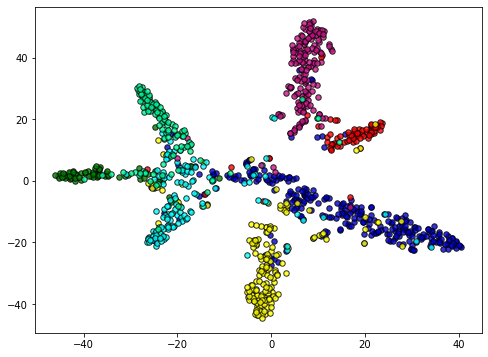

In [31]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

ts = TSNE(n_components=2)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(8, 6))
for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='o',alpha=0.8,edgecolors='black')